# Lecture 24 - Sequential Monte Carlo in `PyMC3`

In [1]:
import numpy as np
import pymc3 as pm
import theano as T
from theano import shared, function, tensor as tt
from sample_smc import sample_smc 

try:
    import sympy
except:
    _=!pip install sympy
    import sympy

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import logging

%matplotlib inline 

## Objectives

+ Compute the model evidence using `PyMC3`.
+ Do model selection with `PyMC3`.

## Sanity check - Does the calculation of the evidence with PySMC work?

Let
$$
p(\theta) = \mathcal{N}(\theta|0, 1),
$$
and
$$
p(y|\theta) = \mathcal{N}(y|\theta,0).
$$
The posterior of $\theta$ given $y$ is:
$$
p(\theta|y) = \frac{p(y|\theta)p(\theta)}{Z},
$$
where
$$
Z = \int_{-\infty}^{\infty} p(y|\theta)p(\theta)d\theta.
$$
Let's first calculate $Z$ analytically.

In [2]:
import sympy.stats
sympy.init_printing()
y, t = sympy.symbols('y \\theta')
q = 1. / sympy.sqrt(2. * sympy.pi) * sympy.exp(-0.5 * (y - t) ** 2) * \
    1. / sympy.sqrt(2. * sympy.pi) * sympy.exp(-0.5 * t ** 2)
sympy.simplify(sympy.integrate(q, (t, -sympy.oo, sympy.oo)))

So, if the observed $y$ was zero, then the Z should be:
$$
Z = \frac{1}{2\sqrt{\pi}}.
$$

In [3]:
Z = 1 /  2. / np.sqrt(np.pi)
print('log Z = {0:.3f}'.format(np.log(Z)))

log Z = -1.266


All, right. Now, let's program this thing in pysmc and compare the results.

We start with the model:

In [4]:
model = pm.Model()
yobs = 0.
with model:
    # prior over theta 
    theta = pm.Normal('theta', mu=0., sigma=1.,testval=0.)
    
    # log likelihood 
    llk = pm.Potential('llk', pm.Normal.dist(theta, 1.).logp(yobs))
    
    trace, smcres = sample_smc(1000)

Sample initial stage: ...
/Users/krishnan/Documents/uq-course/.venv/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 1.000 Steps:  25 Acce: 1.000


In [8]:
print(vars(smcres.model))

{'_parent': None, '_theano_config': {'compute_test_value': 'raise'}, '_config_context': <theano.configparser._ChangeFlagsDecorator object at 0x10c7cdbb0>, 'name': '', 'coords': {}, 'RV_dims': {}, 'check_bounds': True, 'named_vars': {'theta': theta ~ Normal, 'llk': llk}, 'free_RVs': [theta ~ Normal], 'observed_RVs': [], 'deterministics': [], 'potentials': [llk], 'missing_values': [], 'theta': theta ~ Normal, 'llk': llk, 'marginal_log_likelihood': -1.2642191580115534, '_bijection_cache': LRUCache([((), <pymc3.blocking.DictToArrayBijection object at 0x12e6b2640>)], maxsize=128, currsize=1)}


In [9]:
# get the model evidence 
log_evidence_smc = smcres.model.marginal_log_likelihood
print('True log evidence: %.4f \nSMC log evidence: %.4f'%(np.log(Z), log_evidence_smc))

True log evidence: -1.2655 
SMC log evidence: -1.2642


Which is close to the truth.

### Questions

+ Repeat the calculations above for a varying number of SMC particles. Start from 10 and go up to 10,000.

## Polynomial Regression

In [10]:
def compute_design_matrix(X, phi):
    """
    Arguments:
    
    X   -  The observed inputs (1D array)
    phi -  The basis functions.
    """
    num_observations = X.shape[0]
    num_basis = phi.num_basis
    Phi = np.ndarray((num_observations, num_basis))
    for i in range(num_observations):
        Phi[i, :] = phi(X[i, :])
    return Phi

class PolynomialBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    degree  -  The degree of the polynomial.
    """
    def __init__(self, degree):
        self.degree = degree
        self.num_basis = degree + 1
    def __call__(self, x):
        return np.array([x[0] ** i for i in range(self.degree + 1)])
    

class FourierBasis(object):
    """
    A set of linear basis functions.
    
    Arguments:
    num_terms  -  The number of Fourier terms.
    L          -  The period of the function.
    """
    def __init__(self, num_terms, L):
        self.num_terms = num_terms
        self.L = L
        self.num_basis = 2 * num_terms
    def __call__(self, x):
        res = np.ndarray((self.num_basis,))
        for i in range(num_terms):
            res[2 * i] = np.cos(2 * i * np.pi / self.L * x[0])
            res[2 * i + 1] = np.sin(2 * (i+1) * np.pi / self.L * x[0])
        return res
    

class RadialBasisFunctions(object):
    """
    A set of linear basis functions.
    
    Arguments:
    X   -  The centers of the radial basis functions.
    ell -  The assumed lengthscale.
    """
    def __init__(self, X, ell):
        self.X = X
        self.ell = ell
        self.num_basis = X.shape[0]
    def __call__(self, x):
        return np.exp(-.5 * (x - self.X) ** 2 / self.ell ** 2).flatten()

Let's generate some fake data.

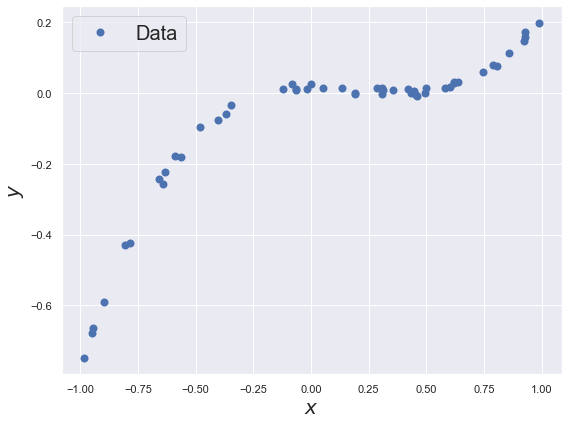

In [11]:
np.random.seed(12345)
def getdata(N, sigma2):
    X = 2 * np.random.rand(N) - 1.
    y = 0.5 * X  ** 3 - 0.3 * X ** 2 + np.sqrt(sigma2) * np.random.rand(N)
    return X, y

num_samples = 50
sigma2 = 1e-3
X, y = getdata(num_samples, sigma2)
plt.figure(figsize=(8, 6))
plt.plot(X, y, 'o', markeredgewidth=2, label='Data')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

We are going to implement a standard Bayesian linear regression and train it with `PyMC3`.
We will compute the evidence in order to select the best class of basis functions.
The model is as follows:

The output $y$ conditioned on the input $x$, the weights of the basis functions $w$ and
the noise variance $\sigma^2$ has likelihood:
$$
p(y|x,w,\sigma, \mathcal{M}) = \mathcal{N}(y|w^T\phi_{\mathcal{M}}(x), \sigma^2),
$$
where $\phi_{\mathcal{M},1}(\cdot), \dots, \phi_{\mathcal{M},m_{\mathcal{M}}}(\cdot)$ are the
$m_{\mathcal{M}}$ basis functions of the model $\mathcal{M}$.
We put a normal prior on the weights:
$$
p(w|\alpha) = \mathcal{N}(w|0, \alpha I_{m_{\mathcal{M}}}),
$$
and an inverse Gamma prior for $\sigma$ and $\alpha$:
$$
p(\sigma^2) = \mathrm{IG}(\sigma^2|1, 1),
$$
and
$$
p(\alpha) = \mathrm{IG}(\alpha|1,1).
$$

Assume that the data we have observed are:
$$
x_{1:n} = \{x_1,\dots,x_n\},\;\mathrm{and}\;y_{1:n} = \{y_1,\dots,y_n\}.
$$
Consider the design matrix $\Phi_{\mathcal{M}}\in\mathbb{R}^{n\times m}$:
$$
\Phi_{\mathcal{M},ij} = \phi_{\mathcal{M},j}(x_i).
$$
The likelihood of the data is:
$$
p(y_{1:n} | x_{1:n}, w, \sigma, \mathcal{M}) = \mathcal{N}(y_{1:n}|\Phi_{\mathcal{M}}w, \sigma^2I_n).
$$
Let's turn this into `PyMC3` code.

In [12]:
def make_model(Phi, y):
    """
    INPUTS:
        Phi -> Design matrix.
        y   -> Target vector. 
        
    RETURNS:
        model -> `pymc3.model` context.
    """
    num_data, num_features = Phi.shape
    
    # define the model 
    with pm.Model() as model:
        # prior on the weights 
        alpha = pm.InverseGamma('alpha', alpha=1., beta=1.)
        w = pm.Normal('w', mu=0., tau=alpha, shape=num_features)
        
        # prior on the likelihood noise variance 
        sigma2 = pm.InverseGamma('sigma2', alpha=5., beta=0.1)
        
        # the data likelihood mean 
        ymean = pm.Deterministic('ymean', tt.dot(Phi, w))
        
        # likelihood 
        y = pm.Normal('y', ymean, sigma2, shape=num_data, observed=y)
        #llk = pm.Potential('llk', pm.Normal.dist(ymean, tt.sqrt(sigma2)).logp_sum(y))
    return model

Now, let's create a function that trains the model using pysmc for a polynomial basis with a given order.

In [13]:
def fit_poly(phi, X, y, num_particles=100):
    """
    
    RETURNS:
        1. An instance of pymc3.Model for the SMC model.
        2. The SMC trace.
        3. An instance of pymc3.smc.SMC containing sampling information.
    """
    Phi = compute_design_matrix(X[:, None], phi)
    smcmodel = make_model(Phi, y)
    trace, res = sample_smc(draws=num_particles, 
                         model=smcmodel, 
                         progressbar=True, 
                         threshold=0.8)
    return smcmodel, trace, res

phi = PolynomialBasis(3)
model, trace, res = fit_poly(phi, X, y)

Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000


Stage:   1 Beta: 0.000 Steps:  25 Acce: 0.155


Stage:   2 Beta: 0.000 Steps:  25 Acce: 0.237


Stage:   3 Beta: 0.000 Steps:  17 Acce: 0.195


Stage:   4 Beta: 0.000 Steps:  21 Acce: 0.206


Stage:   5 Beta: 0.001 Steps:  19 Acce: 0.247


Stage:   6 Beta: 0.001 Steps:  16 Acce: 0.246


Stage:   7 Beta: 0.003 Steps:  16 Acce: 0.263


Stage:   8 Beta: 0.004 Steps:  15 Acce: 0.329


Stage:   9 Beta: 0.007 Steps:  11 Acce: 0.252


Stage:  10 Beta: 0.013 Steps:  15 Acce: 0.209


Stage:  11 Beta: 0.020 Steps:  19 Acce: 0.196


Stage:  12 Beta: 0.029 Steps:  21 Acce: 0.238


Stage:  13 Beta: 0.042 Steps:  16 Acce: 0.263


Stage:  14 Beta: 0.057 Steps:  15 Acce: 0.254


Stage:  15 Beta: 0.075 Steps:  15 Acce: 0.256


Stage:  16 Beta: 0.095 Steps:  15 Acce: 0.227


Stage:  17 Beta: 0.118 Steps:  17 Acce: 0.239


Stage:  18 Beta: 0.147 Steps:  16 Acce: 0.286


Stage:  19 Beta: 0.182 Steps:  13 Acce: 0.311


Stage:  20 Beta: 0.230 Steps:  12 Acce: 0.267


Stage:  21 Beta: 0.299 Steps:  14 Acce: 0.287


Stage:  22 Beta: 0.389 Steps:  13 Acce: 0.264


Stage:  23 Beta: 0.511 Steps:  15 Acce: 0.270


Stage:  24 Beta: 0.645 Steps:  14 Acce: 0.281


Stage:  25 Beta: 0.825 Steps:  13 Acce: 0.212


Stage:  26 Beta: 1.000 Steps:  19 Acce: 0.245


### Postprocessing 

Once you have the `trace` object for the SMC simulation you can apply all the standard postprocessing tools from `PyMC3` as usual. 

Here's the posterior distribution over the weights precision and the the likelihood noise, $\alpha$ and $\sigma^2$ respectively:

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/krishnan/Documents/uq-course/.venv/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


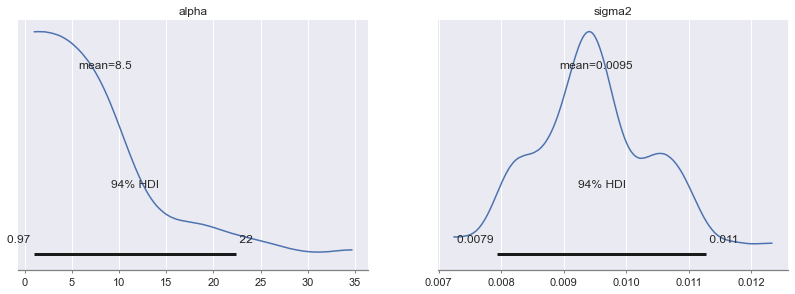

In [14]:
_=pm.plot_posterior(trace, var_names=['alpha', 'sigma2'])

Here's the posterior predictive mean of the output $y$, i.e., $\mathbb{E}[y|x, w, \sigma]$:

In [15]:
ppsamples = pm.sample_posterior_predictive(model=model, 
                               trace=trace, var_names=['ymean'])['ymean']

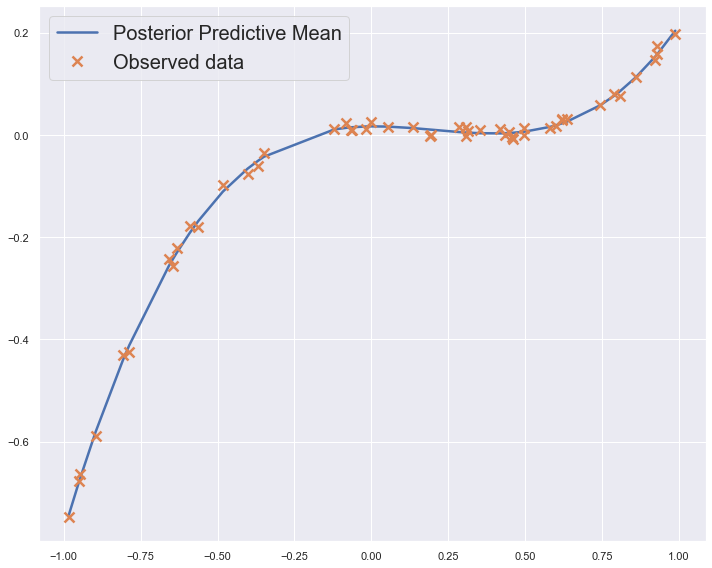

In [16]:
idx = np.argsort(X)
plt.figure(figsize=(10, 8))
plt.plot(X[idx], ppsamples.mean(0)[idx], linewidth=2.5, label='Posterior Predictive Mean' )
plt.plot(X, y, 'x', markeredgewidth=2.5, markersize=10, label='Observed data')

plt.legend(loc='best', fontsize=20)
plt.tight_layout()

SMC does a particle approximation of the posterior distribution. The particles themselves can be obtained from the `trace` object and the particle weights can be obtained from the  `res` object. 

Recall that the approximate posterior distribution is of the form $p(\theta|\mathcal{D}) = \sum_{j=1}^{N} w_j \delta(\theta - \theta_j)$.

In [17]:
particles_w = trace.w
particles_alpha = trace.alpha
particle_weights = res.weights   # <- these are the ws from the above equation

## Model comparison

Since SMC can approximate the model evidence it provides a principled way of comparing models. Let's compare 5 different polynomial regression models where we change the degree of the polynomial from 1 to 5. 

In [18]:
# Evaluate the evidence for the various degrees
log_Zs = []
D = [1, 2, 3, 4, 5]
for d in D:
    phi = PolynomialBasis(d)
    _, _, res = fit_poly(phi, X, y, num_particles=500)
    log_Z = np.log(res.model.marginal_likelihood)
    log_Zs.append(log_Z)

Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000


Stage:   1 Beta: 0.000 Steps:  25 Acce: 0.253


Stage:   2 Beta: 0.000 Steps:  15 Acce: 0.260


Stage:   3 Beta: 0.000 Steps:  15 Acce: 0.239


Stage:   4 Beta: 0.001 Steps:  16 Acce: 0.283


Stage:   5 Beta: 0.001 Steps:  13 Acce: 0.263


Stage:   6 Beta: 0.002 Steps:  15 Acce: 0.248


Stage:   7 Beta: 0.004 Steps:  16 Acce: 0.248


Stage:   8 Beta: 0.006 Steps:  16 Acce: 0.237


Stage:   9 Beta: 0.010 Steps:  17 Acce: 0.242


Stage:  10 Beta: 0.016 Steps:  16 Acce: 0.232


Stage:  11 Beta: 0.026 Steps:  17 Acce: 0.240


Stage:  12 Beta: 0.043 Steps:  16 Acce: 0.243


Stage:  13 Beta: 0.069 Steps:  16 Acce: 0.245


Stage:  14 Beta: 0.108 Steps:  16 Acce: 0.242


Stage:  15 Beta: 0.177 Steps:  16 Acce: 0.237


Stage:  16 Beta: 0.280 Steps:  17 Acce: 0.240


Stage:  17 Beta: 0.448 Steps:  16 Acce: 0.268


Stage:  18 Beta: 0.700 Steps:  14 Acce: 0.257


Stage:  19 Beta: 1.000 Steps:  15 Acce: 0.256


AttributeError: 'Model' object has no attribute 'marginal_likelihood'

In [ ]:
for d, log_Z in zip(D, log_Zs):
    print('degree %d gives %.4f'%(d, log_Z))

degree 1 gives 25.0212
degree 2 gives 41.0753
degree 3 gives 142.4574
degree 4 gives 139.3597
degree 5 gives 137.5729


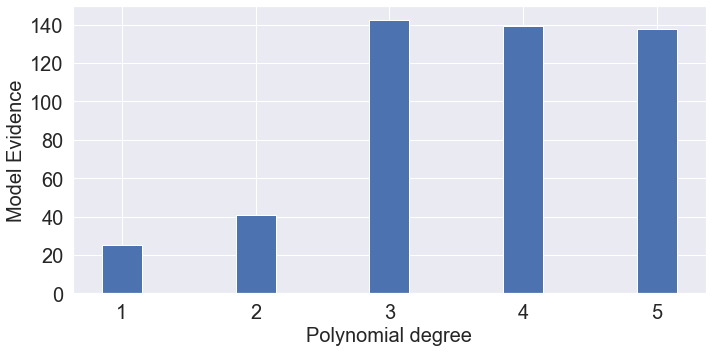

In [ ]:
plt.figure(figsize=(10, 5))
_=plt.bar(D, log_Zs, width=0.3)
_=plt.xticks(D)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Polynomial degree', fontsize=20)
plt.ylabel('Model Evidence', fontsize=20)
plt.tight_layout()

## Questions
+ The model with degree 3 polynomials has the gradest evidence. However, the degree 4 and 5 seem also very plausible. Is this a problem for the theory of Bayesian model selection? What complicates things here, is that model 3 is included in model 4 which is included in model 5. This requires us to design special priors for the models being right. They have to be consistent in some sense. For example, if model 3 is right then model 4 must be right, etc.

+ Revisit the motorcycle dataset problem. Evaluate the model evidence for a 1) Polynomial basis; 2) a Fourier basis; and 3) a Radial basis function basis.

## Revisiting Challenger Disaster Problem (Model Selection)

In [ ]:
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
# drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# plot it, as a function of temperature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


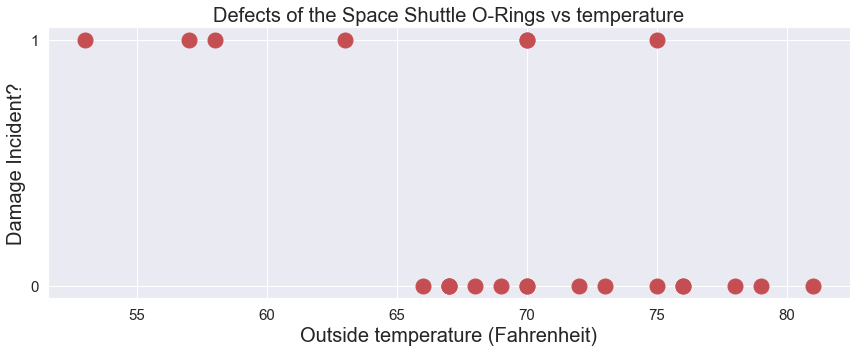

In [ ]:
# plot it, as a function of temperature (the first column)
plt.figure(figsize=(12, 5))
plt.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro', 
         markersize=15)
plt.ylabel("Damage Incident?",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks([0, 1], fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()

In [ ]:
# gather the data and apply preprocessing if any 
temp = challenger_data[:, 0]
temp_scaled = (temp - np.mean(temp))/np.std(temp)
data = challenger_data[:, 1]

# instantiate the pymc3 model
challenger_model = pm.Model()

# define the graph 
with challenger_model:
    # define the prior
    alpha = pm.Normal('alpha', mu=0., sigma=10.)
    beta = pm.Normal('beta', mu=0., sigma=10.)
    
    # get the probabilities of failure at each observed temp 
    p = pm.Deterministic('p', 1./(1. + tt.exp(alpha + beta*temp_scaled)))
    
    # define the likelihood 
    x = pm.Bernoulli('x', p=p, observed=data)
print("Challenger space shuttle disaster model:")
challenger_model

Challenger space shuttle disaster model:


In [ ]:
num_particles = 500
trace, smc = sample_smc(model=challenger_model, 
                           draws=num_particles,
                          threshold=0.8, 
                          progressbar=True)

Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000

100%|██████████| 500/500 [00:00<00:00, 1192.56it/s]
Stage:   1 Beta: 0.011 Steps:  25 Acce: 0.549

100%|██████████| 500/500 [00:00<00:00, 5654.91it/s]
Stage:   2 Beta: 0.028 Steps:   5 Acce: 0.406

100%|██████████| 500/500 [00:00<00:00, 3532.90it/s]
Stage:   3 Beta: 0.056 Steps:   8 Acce: 0.346

100%|██████████| 500/500 [00:00<00:00, 2808.64it/s]
Stage:   4 Beta: 0.106 Steps:  10 Acce: 0.301

100%|██████████| 500/500 [00:00<00:00, 2361.99it/s]
Stage:   5 Beta: 0.182 Steps:  12 Acce: 0.275

100%|██████████| 500/500 [00:00<00:00, 2041.58it/s]
Stage:   6 Beta: 0.313 Steps:  14 Acce: 0.266

100%|██████████| 500/500 [00:00<00:00, 2076.29it/s]
Stage:   7 Beta: 0.529 Steps:  14 Acce: 0.250

100%|██████████| 500/500 [00:00<00:00, 1943.86it/s]
Stage:   8 Beta: 0.897 Steps:  15 Acce: 0.270

100%|██████████| 500/500 [00:00<00:00, 2060.88it/s]
Stage:   9 Beta: 1.000 Steps:  14 Acce: 0.261

100%|██████████| 500/500 [00:00<00:0

In [ ]:
ppsamples = pm.sample_posterior_predictive(model=challenger_model, 
                                           trace=trace, 
                                           var_names=['p'])['p']


100%|██████████| 500/500 [00:00<00:00, 3612.98it/s]


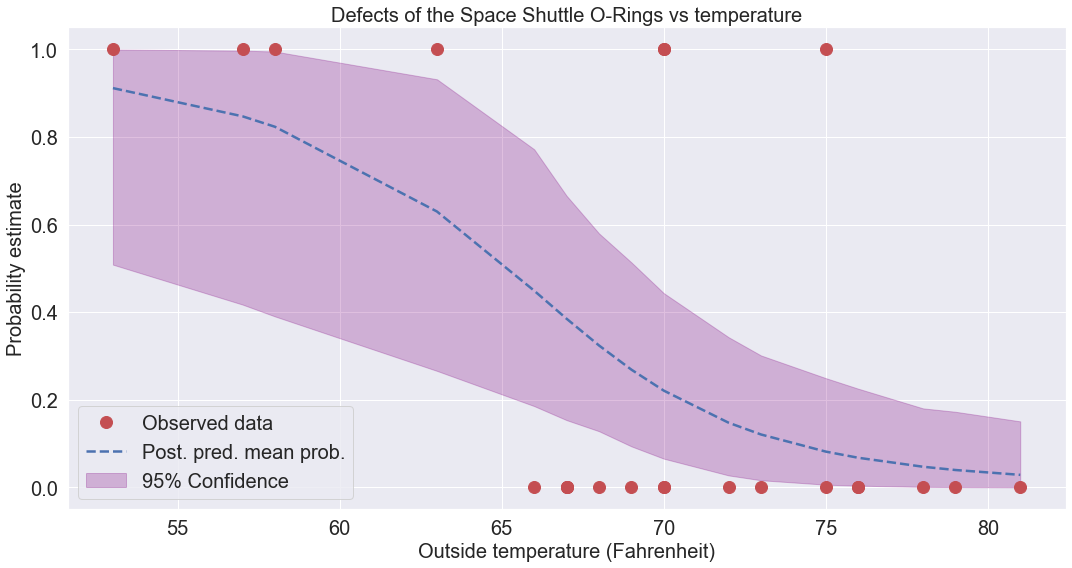

In [ ]:
ppmean = ppsamples.mean(0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])

plt.figure(figsize=(15, 8))
plt.plot(temp, data, 'ro', markersize=12, label='Observed data')
idx=np.argsort(temp)
plt.plot(temp[idx], ppmean[idx], linestyle='--', linewidth=2.5, 
         label='Post. pred. mean prob.')
plt.fill_between(temp[idx], pp_lower[idx], pp_upper[idx], 
                color='purple', alpha=0.25, label='95% Confidence')
plt.ylabel("Probability estimate",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks(np.arange(0., 1.01, 0.2), fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.tight_layout()

In [ ]:
logZ_temp = np.log(smc.model.marginal_likelihood)